https://github.com/jwilsson/spotify-web-api-php/blob/main/docs/examples/working-with-scopes.md
https://docs.google.com/document/d/1Fy9aKwfZ1OY6RmsmPCBHVnkZGVKqVPyaYz9ScJlVb6U/edit

# Outmoded Functions

In [ ]:
def plotTopSongs(df_tracks):
    top_5_songs = df_tracks.sort_values(ascending=False,by='popularity')[:5]
    y = list(top_5_songs.popularity)
    x = list(top_5_songs.title)
    plt.bar(x, y, color ='purple', width = 0.5)
    plt.xlabel("Song Title")
    plt.xticks(rotation=90)
    plt.ylabel("Popularity")
    plt.title("Top 5 Most Popular Songs in Playlist")
    plt.show()

t = time.process_time()
plotTopSongs(df_tracks)
elapsed_time = time.process_time() - t
print('Time elapsed:', elapsed_time,'s')


def plotOverallTopArtists(artists_df):
    top_5_artists = artists_df.sort_values(ascending=False,by='popularity')[:5]
    y = list(top_5_artists.popularity)
    x = list(top_5_artists.name)
    plt.bar(x, y, color ='purple', width = 0.4)
    plt.xlabel("Artist")
    plt.ylabel("Popularity")
    plt.title("Top 5 Spotify Artists in Playlist")
    plt.show()

t = time.process_time()
plotOverallTopArtists(artists_df)
elapsed_time = time.process_time() - t
print('Time elapsed:', elapsed_time,'s')


# Authorization & Set-up

In [117]:
import time
import os
import requests
import base64
from dotenv import load_dotenv
import json
from urllib.parse import urlencode
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import random

from bokeh.plotting import figure, show, output_notebook, ColumnDataSource
from bokeh.models import HoverTool, Div
from bokeh.layouts import column
from bokeh.io import curdoc

In [2]:
AUTH_URL = 'https://accounts.spotify.com/api/token'
BASE_URL = 'https://api.spotify.com/v1/'

In [3]:
def getAuth():
    # Retrieve client ID & secret from env file & encode.
    dotenv_path = '/Users/mariam/Documents/GitHub/advanced_python/credentials.env' # Put your credentials in.
    load_dotenv(dotenv_path=dotenv_path)  # Use the path for dotenv
    
    client_id, client_secret = os.environ.get('client_id'), os.environ.get('client_secret') #verify var names.
    credentials = f"{client_id}:{client_secret}"
    credentials_b64 = base64.b64encode(credentials.encode())
    
    url = 'https://accounts.spotify.com/api/token'
    token_data = {'grant_type': 'client_credentials'}
    headers = {
        'Content-Type': 'application/x-www-form-urlencoded',
        'Authorization': f'Basic {credentials_b64.decode()}'
    }
    
    response = requests.post(url, data=token_data, headers=headers)
    if response.ok:
        return response.json().get('access_token')
    else:
        print(f"Invalid: {response.status_code}, {response.text}")
        return None

# Playlist(S)

In [9]:
def getPlaylists(access_token):
    user_id = os.environ.get('user_id')
    headers = {
        "Authorization": f"Bearer {access_token}"
    }
    response = requests.get(f"{BASE_URL}users/{user_id}/playlists", headers=headers)
    if response.ok:
        return response.json()
    else:
        print(f"Invalid: {response.status_code}, {response.text}")
    return None

def dfPlaylists(user_playlists):
    df_playlists = pd.json_normalize(user_playlists['items'], sep = '_', record_prefix = 'playlist_', errors = 'ignore')
    return df_playlists

def getColumns(df, relevant_columns):
    cleaned_columns = [col for col in relevant_columns if col in df.columns]
    return df[cleaned_columns]

In [10]:
def getPlaylist(playlist_id, access_token):
    headers = {
    "Authorization": f"Bearer {access_token}"
    }

    response = requests.get(f"{BASE_URL}playlists/{playlist_id}", headers=headers)
    if response.ok:
        return response.json()
    else:
        print(f"Invalid: {response.status_code}, {response.text}")
    return None

def dfPlaylist(json_data):
    playlist_info = {
    'playlist_name': json_data['name'],
    'total_tracks': json_data['tracks']['total'],
    'description': json_data['description'],
    'followers': json_data['followers']['total']
    }
        
    tracks = []
    for item in json_data['tracks']['items']:
        track = item['track']
        track_info = {
            'id': track['id'],
            'title': track['name'],
            'popularity': track['popularity'],
            'album': track['album']['name'],
            'release_date': track['album']['release_date'],
            'album_total_tracks': track['album']['total_tracks'],
            'artist': track['artists'][0]['name'] if track['artists'] else None,  # Assuming first artist as the main
            'artist_id': track['artists'][0]['id'] if track['artists'] else None, 
            'album_id': track['album']['id']
        }
        tracks.append(track_info)
    df_tracks = pd.DataFrame(tracks)
    
    return playlist_info, df_tracks

# Audio Features

In [11]:
def genretoPlaylist(df_tracks, df_artists): # Determine how to flow this.
    df_tmp_genre = pd.Series(df_artists.set_index('id')['genres'].to_dict())
    df_tracks['genres'] = df_tracks['artist_id'].map(df_tmp_genre)
    return df_tracks

def getAudiosFeatures(track_ids, access_token):

    track_ids = ",".join(track_ids) 
    headers = {
        "Authorization": f"Bearer {access_token}"
    }

    response = requests.get(f"{BASE_URL}audio-features?ids={track_ids}", headers=headers)
    if response.ok:
        return response.json()
    else:
        print(f"Invalid: {response.status_code}, {response.text}")
    return None

def audioFeaturesDf(audio_features_json): #Max 100 track ids.
    #if 'audio_features' key exists and use its value, otherwise use the input directly.
    features_list = audio_features_json['audio_features'] if 'audio_features' in audio_features_json else audio_features_json
    
    features_data = []
    for feature in features_list:
        if feature:  # if feature not None.
            features = {
                'danceability': feature['danceability'],
                'energy': feature['energy'],
                'key': feature['key'],
                'loudness': feature['loudness'],
                'mode': feature['mode'],
                'speechiness': feature['speechiness'],
                'acousticness': feature['acousticness'],
                'instrumentalness': feature['instrumentalness'],
                'liveness': feature['liveness'],
                'valence': feature['valence'],
                'tempo': feature['tempo'],
                'duration_ms': feature['duration_ms'],
                'time_signature': feature['time_signature']
            }
            # Include track ID as the dictionary key if present.
            if 'id' in feature:
                features['id'] = feature['id']
            features_data.append(features)
    
    df_features = pd.DataFrame(features_data)
    if 'id' in df_features.columns:
        df_features.set_index('id', inplace=True)
    return df_features

# Artists

In [12]:
def getArtist(artist_ids, access_token):

    artist_ids = ",".join(artist_ids) 
    headers = {
        "Authorization": f"Bearer {access_token}"
    }
    response = requests.get(f"{BASE_URL}artists?ids={artist_ids}", headers=headers)
    if response.ok:
        return response.json()
    else:
        print(f"Invalid: {response.status_code}, {response.text}")
    return None

def ArtistDf(artist_json):
    artists = []
    for artist in artist_json['artists']:
        artist_info = {
            'followers': artist['followers']['total'],
            'genres': artist['genres'],  # Store the entire list of genres. Think how to handle empty?
            'id': artist['id'],
            'name': artist['name'],
            'popularity': artist['popularity']
        }
        artists.append(artist_info)
    df_artists = pd.DataFrame(artists)
    return df_artists


# Testing & Data Set-up

In [86]:
# Select Playlist to analyze.

t = time.process_time()
access_token = getAuth()
user_playlists = getPlaylists(access_token)
tmp_df = dfPlaylists(user_playlists)
playlists_original_df = getColumns(tmp_df,['id','name', 'tracks_total'])
elapsed_time = time.process_time() - t
print('Time elapsed:', elapsed_time,'s')

playlists_original_df.head(20)

Time elapsed: 0.07285300000000206 s


,id,name,tracks_total
0,2NhLGiv2PHFUIbnOZHWNMa,ambient fall,24
1,4tuidaUoNXX2McknYwFLbv,28 🌈 flying bus,35
2,0S9MSwe373QOgtnhM7eT8k,re:shoegaze,27
3,1mDe0VUqjQra7jRgz7Eycv,strictly house,209
4,7lVGHsv17UPEiP9WOUIyeA,Top 100 Mix,101
5,7weKiLcZizpqHvtkegQhi9,TechnoWErk,4
6,4tbHfb0XHczaV8sBH5vkX6,Dramatics,28
7,3oJJF6tWKAUg1be9JRB9vo,Indie Electronics,187
8,7yzlQqZTrcfXThvLYmEsgZ,Classiques seulement,79
9,4de72d5zl6iGyxrHhMtuMj,Oldies,405


In [87]:
# See track details from indicated playlist.

t = time.process_time()
playlist = getPlaylist('2NhLGiv2PHFUIbnOZHWNMa', access_token)
info, df_tracks = dfPlaylist(playlist)
elapsed_time = time.process_time() - t
print('Time elapsed:', elapsed_time,'s')

df_tracks.head(20) 

Time elapsed: 0.03769299999999731 s


,id,title,popularity,album,release_date,album_total_tracks,artist,artist_id,album_id
0,1mQ3ryvTBSWeEMkH0Ul4gK,Calibre,48,Lô Borges,1972-01-01,15,Lô Borges,1mZbRiSVb2ExneAlDbBiiT,0fXZAZ5XejnxhgRV38SH5I
1,38dNnsL9yYygLYiX5ORf6B,FRENCH BOSSA NOVA,52,FRENCH BOSSA NOVA,2023-08-25,1,Ladji Mouflet,2NNTIDSDRlsf4lzYW9fpKm,1U25ArvtrbFkbAgke4NltV
2,21s0bjVrP7RtQskeUKZxOu,Soul Makossa,49,Manu Dibango Anthology,2000-01-01,34,Manu Dibango,30UIjoCGuL3Fa5BOc3ayNW,4WDsHhoLJTSGVAt7ydCoPN
3,7nZ9CzhiFRPhOQCn7eDSnn,Vanille fraise,62,Vanille fraise,2015,1,L'Impératrice,4PwlsrN0t5mLN0C827cbEU,41Ht5x3AgpMVmoFoIzaUPO
4,2xGlUVrlvnv4wf8AL3owDd,Vivre Pour Vivre - Instrumental,42,Francis Lai: The Essential Film Music Collection,2011-02-07,20,フランシス・レイ,7ENooSqJ9fshrkOLQwaofM,5Q1wvUO3Gw8qIfEbVn2KBB
5,6A9YFkei6zWfPSxWxlBecY,September Rain - 2020 Remaster,49,COLLECTION,2020-03-25,12,Makoto Matsushita,5qm3bAgsYq5aBOymqkM4gG,2jlyowwrLvyN28JGsu4or2
6,67wcAJeaNwGm0fcB4HzzYm,Everything Goes My Way,60,The English Riviera,2011-04-11,11,Metronomy,54QMjE4toDfiCryzYWCpXX,716fnrS2qXChPC3J2X73pK
7,6Xk5AaN4n4SnW71473GI7A,Fast Slow Disco,49,Fast Slow Disco,2018-06-01,1,St. Vincent,7bcbShaqKdcyjnmv4Ix8j6,1uuB4aCSbe5h5ga0wKUi3q
8,4gqDN1M6lY1Dzkr2N0pZDI,Hey Boy,39,Feelings,2021-02-26,11,Brijean,2TRNyrjoKJnqSc9G8jCZfb,0gmjvJvdWuD3AFk9sZ02Yi
9,3ahBKaBhVNiRLOG9RAdwMo,Samba Blim,43,Samba Blim,1968-01-01,12,Tamba 4,4KtH5Ery1JspML3ECanPmZ,2N8i34T56xgmiuN3DI7f34


In [88]:
# View artist level info of relevant tracks in playlist.

t = time.process_time()
artists = getArtist(list(df_tracks.artist_id), access_token) #figue out how to manage id load
df_artists = ArtistDf(artists)
elapsed_time = time.process_time() - t
print('Time elapsed:', elapsed_time,'s')
df_artists.head(100)

Time elapsed: 0.029170000000000584 s


,followers,genres,id,name,popularity
0,149996,"[bossa nova, mpb, musica popular mineira]",1mZbRiSVb2ExneAlDbBiiT,Lô Borges,46
1,9953,[],2NNTIDSDRlsf4lzYW9fpKm,Ladji Mouflet,43
2,88408,"[afrobeat, afropop, makossa, world]",30UIjoCGuL3Fa5BOc3ayNW,Manu Dibango,46
3,537529,"[french indie pop, french indietronica, french...",4PwlsrN0t5mLN0C827cbEU,L'Impératrice,61
4,840,[],7ENooSqJ9fshrkOLQwaofM,フランシス・レイ,27
5,57614,[classic city pop],5qm3bAgsYq5aBOymqkM4gG,Makoto Matsushita,46
6,1023757,"[alternative dance, electronica, french indie ...",54QMjE4toDfiCryzYWCpXX,Metronomy,63
7,836083,"[art pop, etherpop, indie rock, indietronica, ...",7bcbShaqKdcyjnmv4Ix8j6,St. Vincent,63
8,21119,[oakland indie],2TRNyrjoKJnqSc9G8jCZfb,Brijean,41
9,5709,"[brazilian jazz, samba-jazz]",4KtH5Ery1JspML3ECanPmZ,Tamba 4,39


In [89]:
# Add genres (artist level, pulled from df_artist) to df_tracks for easier data accessibility.
df_tracks = genretoPlaylist(df_tracks, df_artists)
df_tracks.head()

,id,title,popularity,album,release_date,album_total_tracks,artist,artist_id,album_id,genres
0,1mQ3ryvTBSWeEMkH0Ul4gK,Calibre,48,Lô Borges,1972-01-01,15,Lô Borges,1mZbRiSVb2ExneAlDbBiiT,0fXZAZ5XejnxhgRV38SH5I,"[bossa nova, mpb, musica popular mineira]"
1,38dNnsL9yYygLYiX5ORf6B,FRENCH BOSSA NOVA,52,FRENCH BOSSA NOVA,2023-08-25,1,Ladji Mouflet,2NNTIDSDRlsf4lzYW9fpKm,1U25ArvtrbFkbAgke4NltV,[]
2,21s0bjVrP7RtQskeUKZxOu,Soul Makossa,49,Manu Dibango Anthology,2000-01-01,34,Manu Dibango,30UIjoCGuL3Fa5BOc3ayNW,4WDsHhoLJTSGVAt7ydCoPN,"[afrobeat, afropop, makossa, world]"
3,7nZ9CzhiFRPhOQCn7eDSnn,Vanille fraise,62,Vanille fraise,2015,1,L'Impératrice,4PwlsrN0t5mLN0C827cbEU,41Ht5x3AgpMVmoFoIzaUPO,"[french indie pop, french indietronica, french..."
4,2xGlUVrlvnv4wf8AL3owDd,Vivre Pour Vivre - Instrumental,42,Francis Lai: The Essential Film Music Collection,2011-02-07,20,フランシス・レイ,7ENooSqJ9fshrkOLQwaofM,5Q1wvUO3Gw8qIfEbVn2KBB,[]


In [90]:
# View audio features of relevnat tracks in playlist.

t = time.process_time()
audio_features = getAudiosFeatures(list(df_tracks.id), access_token)
df_audio_features = audioFeaturesDf(audio_features)
elapsed_time = time.process_time() - t
print(elapsed_time,'s')
df_audio_features.head(100)

0.022211999999999676 s


,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
id,,,,,,,,,,,,,
1mQ3ryvTBSWeEMkH0Ul4gK,0.583,0.418,1,-13.840,0,0.0296,0.7970,0.960000,0.1030,0.695,122.853,89333,4
38dNnsL9yYygLYiX5ORf6B,0.836,0.568,4,-8.190,0,0.1040,0.7250,0.393000,0.1270,0.510,100.062,230400,4
21s0bjVrP7RtQskeUKZxOu,0.831,0.835,0,-3.768,1,0.1420,0.1280,0.002270,0.1340,0.800,114.997,264307,4
7nZ9CzhiFRPhOQCn7eDSnn,0.767,0.547,7,-11.458,0,0.0474,0.0399,0.485000,0.0949,0.660,103.030,238183,4
2xGlUVrlvnv4wf8AL3owDd,0.495,0.245,0,-15.215,1,0.0288,0.8160,0.959000,0.1540,0.221,97.974,191360,3
6A9YFkei6zWfPSxWxlBecY,0.647,0.446,0,-7.089,1,0.0268,0.6610,0.001460,0.0846,0.252,124.030,271951,4
67wcAJeaNwGm0fcB4HzzYm,0.864,0.558,2,-8.196,0,0.0399,0.1020,0.001050,0.1780,0.544,129.969,210080,4
6Xk5AaN4n4SnW71473GI7A,0.606,0.828,10,-7.510,0,0.0577,0.0386,0.000148,0.3130,0.388,113.975,197005,4
4gqDN1M6lY1Dzkr2N0pZDI,0.732,0.927,8,-7.103,0,0.0573,0.1080,0.652000,0.3270,0.629,120.015,195999,4


# Charts

In [133]:

def plotTopGenres(df_artists):
    # Only grabbing first genre to appear for artist.
    first_genres = df_artists['genres'].apply(lambda x: x[0] if isinstance(x, list) and len(x) > 0 else 'Unknown')
    
    genre_counts = first_genres.value_counts()
    total_counts = genre_counts.sum()
    genre_percentages = (genre_counts / total_counts) * 100
    
    data = {
        'genres': genre_counts.index.tolist(),
        'counts': genre_counts.values,
        'percentages': genre_percentages.values
    }
    source = ColumnDataSource(data=data)
    
    p = figure(x_range=data['genres'], title="Top Genres Based on Primary Genre of Artists",
               toolbar_location=None, height=400, tools="")
    
    hover = HoverTool()
    hover.tooltips = [
        ("Genre", "@genres"),
        ("Count", "@counts"),
        ("Percentage", "@percentages{0.2f}%")
    ]
    p.add_tools(hover)
    
    p.vbar(x='genres', top='percentages', width=0.9, source=source,
           fill_color='purple', line_color=None)
    
    p.xaxis.major_label_orientation = 1.2  
    p.xgrid.grid_line_color = None

    p.legend.location = "top_left"
    p.legend.orientation = "horizontal"
    p.legend.background_fill_alpha = 0.0  
    
    output_notebook()  
    show(p)  

plotTopGenres(df_artists)


/var/folders/kj/3n05xf5101nd06t7q93vbtnc0000gn/T/ipykernel_74541/1526948434.py:33: UserWarning: 
You are attempting to set `plot.legend.location` on a plot that has zero legends added, this will have no effect.

Before legend properties can be set, you must add a Legend explicitly, or call a glyph method with a legend parameter set.

  p.legend.location = "top_left"
/var/folders/kj/3n05xf5101nd06t7q93vbtnc0000gn/T/ipykernel_74541/1526948434.py:34: UserWarning: 
You are attempting to set `plot.legend.orientation` on a plot that has zero legends added, this will have no effect.

Before legend properties can be set, you must add a Legend explicitly, or call a glyph method with a legend parameter set.

  p.legend.orientation = "horizontal"
/var/folders/kj/3n05xf5101nd06t7q93vbtnc0000gn/T/ipykernel_74541/1526948434.py:35: UserWarning: 
You are attempting to set `plot.legend.background_fill_alpha` on a plot that has zero legends added, this will have no effect.

Before legend properties can 

Loading BokehJS ...

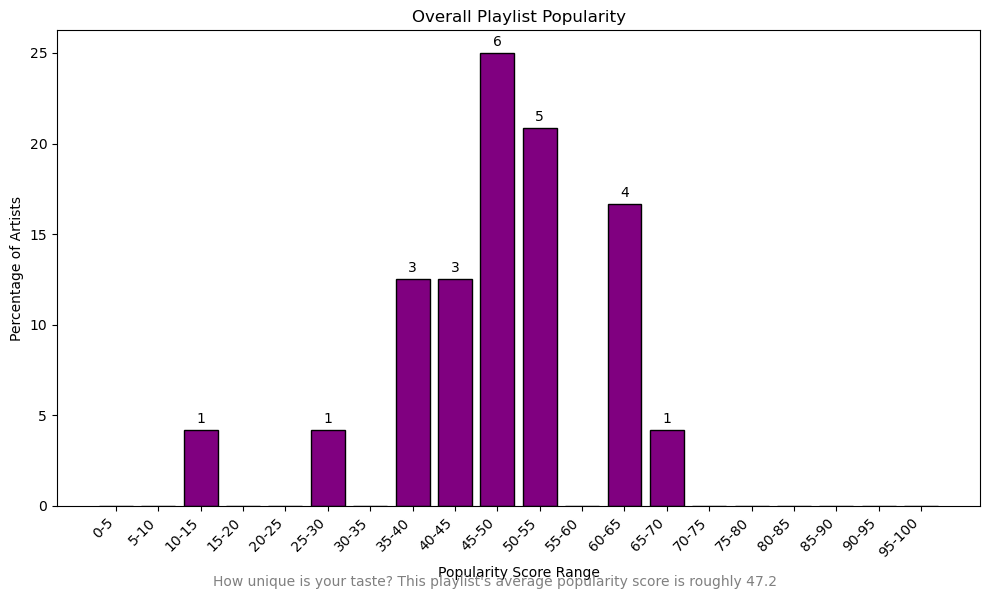

In [122]:
def plotPopularity(df_artists):
    bin_edges = np.arange(0, 105, 5)
    counts, _ = np.histogram(df_artists['popularity'], bins=bin_edges)
    percentages = (counts / df_artists['popularity'].count()) * 100
    avg_popularity = df_artists['popularity'].mean()

    fig, ax = plt.subplots(figsize=(10, 6))
    bars = ax.bar(range(len(bin_edges)-1), percentages, color='purple', edgecolor='black')
    for bar, count in zip(bars, counts):
        if count !=0:
            ax.annotate(f'{count}', 
                        xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()),
                        xytext=(0, 3),  
                        textcoords="offset points",
                        ha='center', va='bottom')

    ax.set_xticks(range(len(bin_edges)-1))
    ax.set_xticklabels([f'{bin_edges[i]}-{bin_edges[i+1]}' for i in range(len(bin_edges)-1)], rotation=45, ha="right")

    ax.set_xlabel('Popularity Score Range')
    ax.set_ylabel('Percentage of Artists')
    ax.set_title('Overall Playlist Popularity')

    caption = f"How unique is your taste? This playlist's average popularity score is roughly {avg_popularity:.1f}"
    fig.text(0.5, 0.01, caption, ha='center', va='bottom', fontsize=10, color='gray')

    plt.tight_layout()
    plt.show()
    
plotPopularity(df_artists)

In [123]:

def plotgenreDiversity(df_artists):
    # Calculate the total number of unique genres across all artists.
    all_genres = set()
    for genres in df_artists['genres']:
        all_genres.update(genres)
    total_unique_genres = len(all_genres)
    
    # Prep data for the top 10 artists by genre count.
    df_artists['genre_count'] = df_artists['genres'].apply(len)
    top_artists = df_artists.nlargest(10, 'genre_count')
    
    source = ColumnDataSource(data=dict(
        names=top_artists['name'],
        counts=top_artists['genre_count'],
        genres=['; '.join(genres) for genres in top_artists['genres']]
    ))
    
    p = figure(x_range=top_artists['name'], height=400, title="Top 10 Artists by Genre Diversity",
               toolbar_location=None, tools="")
    p.vbar(x='names', top='counts', width=0.9, source=source, legend_field="names", 
           line_color='white', fill_color='purple')
    
    p.add_tools(HoverTool(tooltips=[("Artist", "@names"), ("# Genres", "@counts"), ("Genres", "@genres")]))
    
    p.xaxis.major_label_orientation = "vertical"
    p.xgrid.grid_line_color = None
    p.y_range.start = 0
    
    caption_text = f'<div><strong>Total Unique Genres in Playlist: {total_unique_genres}</strong></div>'
    caption = Div(text=caption_text)
    layout = column(p, caption)
    
    output_notebook() # Display plot within the notebook.
    show(layout)
    
plotgenreDiversity(df_artists)

Loading BokehJS ...

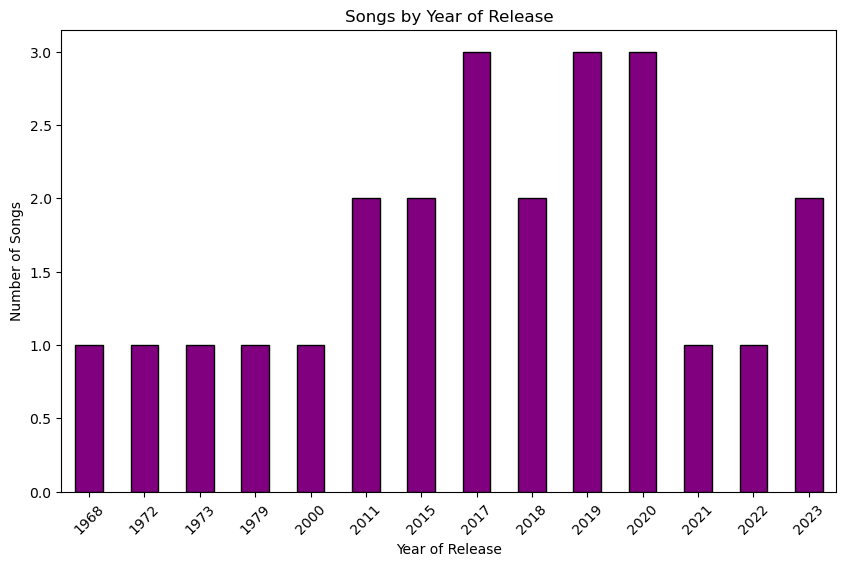

In [134]:
def plotRelease(df_tracks):
    df_tracks['release_year'] = pd.to_datetime(df_tracks['release_date']).dt.year
    tracks_by_year = df_tracks['release_year'].value_counts().sort_index()

    plt.figure(figsize=(10, 6))
    tracks_by_year.plot(kind='bar', color='purple', edgecolor='black') 
    plt.xlabel('Year of Release')
    plt.ylabel('Number of Songs')
    plt.title('Songs by Year of Release')
    plt.xticks(rotation=45)
    plt.show()

plotRelease(df_tracks)

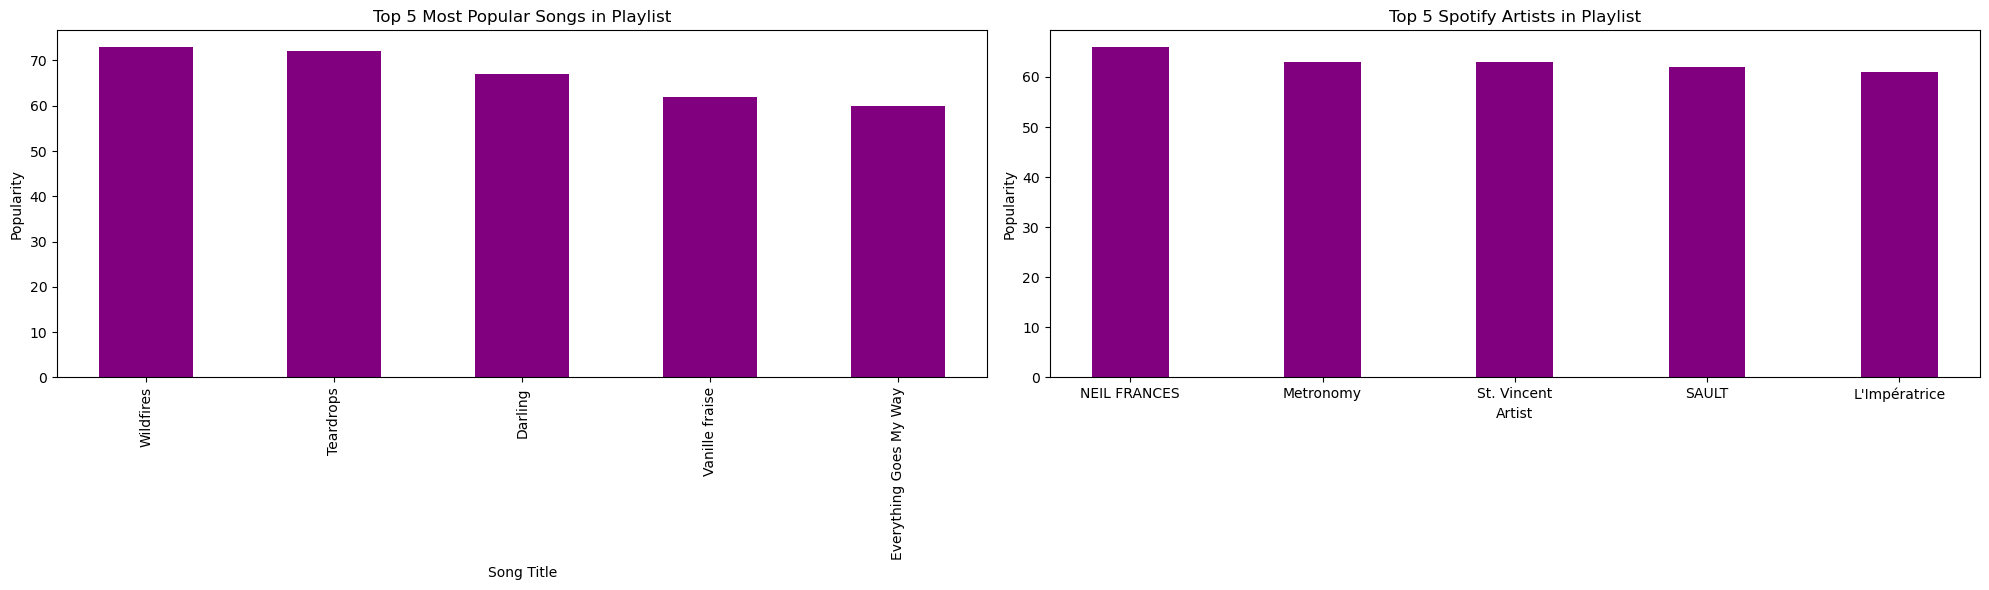

Time elapsed: 0.4835380000000029 s


In [135]:
def plotTopofPlaylist(df_tracks, artists_df):
    fig, axs = plt.subplots(1, 2, figsize=(20, 6)) # 1 row, 2 columns

    top_5_songs = df_tracks.sort_values(ascending=False, by='popularity')[:5]
    axs[0].bar(top_5_songs['title'], top_5_songs['popularity'], color='purple', width=0.5)
    axs[0].set_title('Top 5 Most Popular Songs in Playlist')
    axs[0].set_xlabel('Song Title')
    axs[0].set_ylabel('Popularity')
    axs[0].tick_params(axis='x', rotation=90)

    top_5_artists = artists_df.sort_values(ascending=False, by='popularity')[:5]
    axs[1].bar(top_5_artists['name'], top_5_artists['popularity'], color='purple', width=0.4)
    axs[1].set_title('Top 5 Spotify Artists in Playlist')
    axs[1].set_xlabel('Artist')
    axs[1].set_ylabel('Popularity')
    
    plt.tight_layout()
    plt.show()

t = time.process_time()
plotTopofPlaylist(df_tracks, df_artists)
elapsed_time = time.process_time() - t
print('Time elapsed:', elapsed_time, 's')

/var/folders/kj/3n05xf5101nd06t7q93vbtnc0000gn/T/ipykernel_74541/664216581.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-deep')


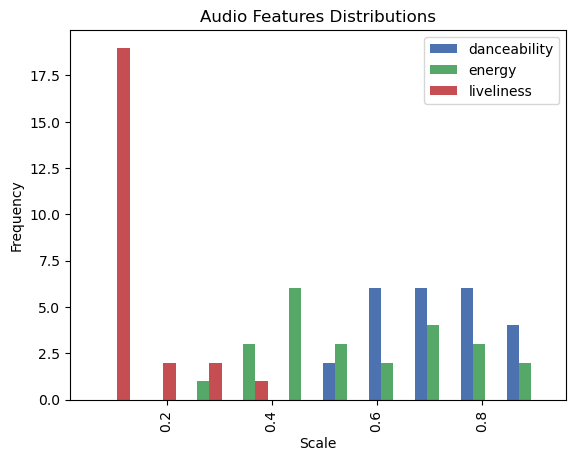

Time elapsed: 0.2862969999999976 s


In [136]:
plt.style.use('seaborn-deep')

def plotAudioFeatures(df_audio_features):
    plt.hist([df_audio_features.danceability, df_audio_features.energy, df_audio_features.liveness], label=['danceability', 'energy', 'liveliness'])
    plt.xlabel("Scale")
    plt.xticks(rotation=90)
    plt.ylabel("Frequency")
    plt.title("Audio Features Distributions")
    plt.legend(loc='upper right')
    plt.show()
    
t = time.process_time()
plotAudioFeatures(df_audio_features)
elapsed_time = time.process_time() - t
print('Time elapsed:', elapsed_time,'s')

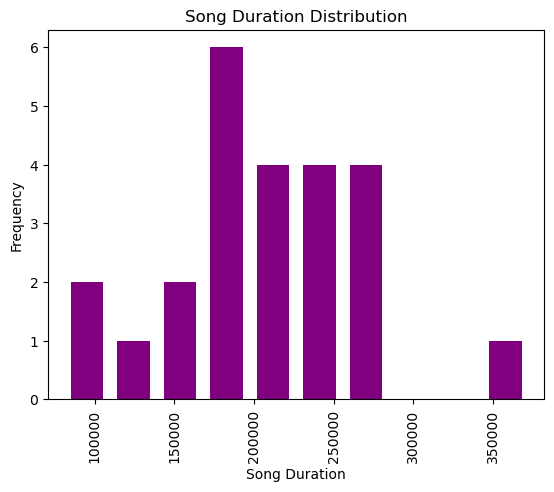

Time elapsed: 0.255227000000005 s


In [137]:
def plotDuration(df_audio_features):
    plt.hist(df_audio_features.duration_ms, color='purple', rwidth=0.7)
    plt.xlabel("Song Duration")
    plt.xticks(rotation=90)
    plt.ylabel("Frequency")
    plt.title("Song Duration Distribution")
    plt.show()

t = time.process_time()
plotDuration(df_audio_features)
elapsed_time = time.process_time() - t
print('Time elapsed:', elapsed_time,'s')

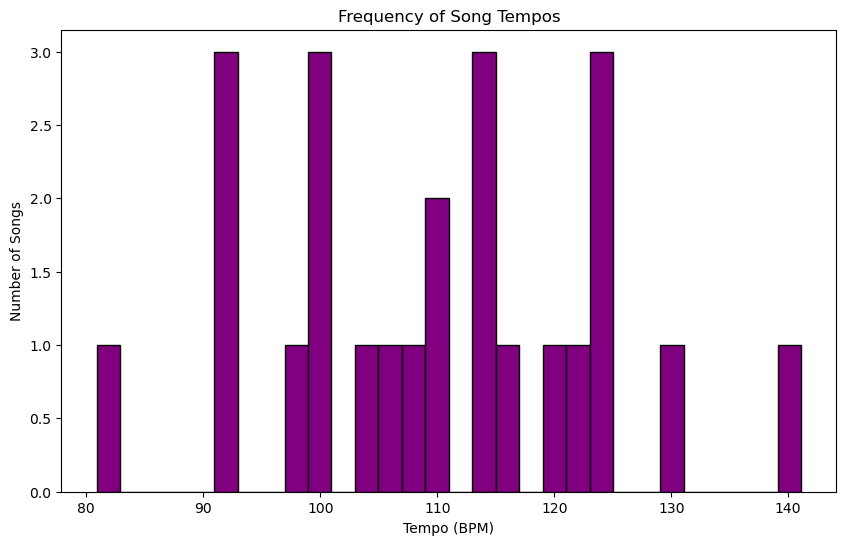

In [138]:
def plotTempo(df_audio_features):
    plt.figure(figsize=(10, 6))
    plt.hist(df_audio_features['tempo'], bins=30, color='purple', edgecolor='black')
    plt.xlabel('Tempo (BPM)')
    plt.ylabel('Number of Songs')
    plt.title('Frequency of Song Tempos')
    plt.show()

plotTempo(df_audio_features)

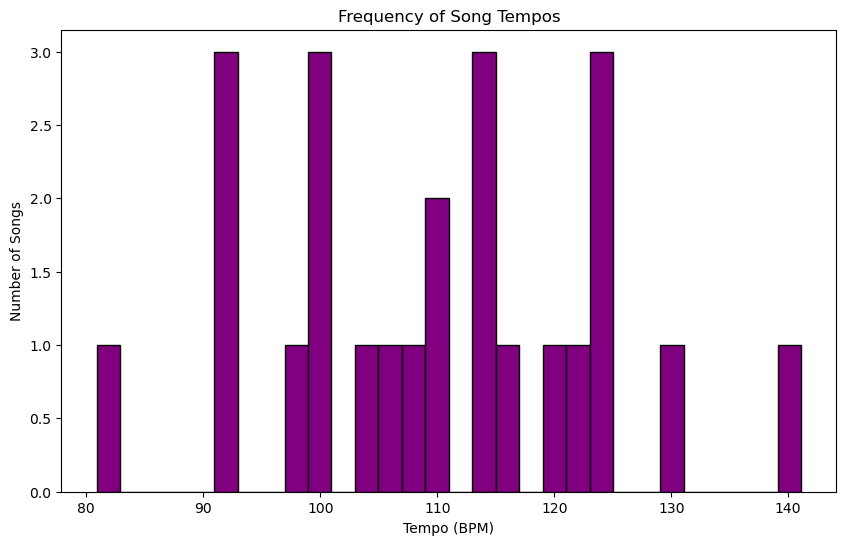

In [29]:
#look for bottlenecks once we have the finalized code
%prun plotTempo(df_audio_features)

# Further Functions - sort/create playlist

In [ ]:
# Need to refine to have the correct scopes.

def createNewPlaylist(access_token, user_id, playlist_name, genres, df_tracks):
    headers = {'Authorization': f'Bearer {access_token}', 'Content-Type': 'application/json'}
    create_playlist_url = f'https://api.spotify.com/v1/users/{user_id}/playlists'
    payload = {
        'name': playlist_name,
        'public': False  # Set to True if the playlist should be public
    }

    # Create the playlist.
    response = requests.post(create_playlist_url, json=payload, headers=headers)
    if not response.ok:
        print(f"Error creating playlist: {response.status_code}, {response.text}")
        return None
    playlist_id = response.json()['id']
    
    # Collect track ids.
    track_ids = []
    for genre in genres:
        track_ids += df_tracks[df_tracks['genre'] == genre]['id'].tolist()

    # Add tracks to the playlist in batches of 100.
    add_tracks_url = f'https://api.spotify.com/v1/playlists/{playlist_id}/tracks'
    for i in range(0, len(track_ids), 100):
        chunk = track_ids[i:i+100]
        payload = {'uris': chunk}
        response = requests.post(add_tracks_url, json=payload, headers=headers)
        if not response.ok:
            print(f"Error adding tracks: {response.status_code}, {response.text}")

    print("Playlist successfully created and tracks added!")

In [ ]:
createNewPlaylist(access_token, os.environ.get('user_id'), "test", ["jazz","bossa nova"], df_tracks)